<a href="https://colab.research.google.com/github/Pakostipup/ML_labs/blob/main/%D0%9B%D0%B0%D0%B1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
!pip install pandas scikit-learn seaborn scipy

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/heart.csv')

df['CHOLNORM'] = np.where(df['CHOL_50'] >= 250, 1, 0)
df.CHOLNORM = df.CHOLNORM.astype('category')

y = df['CHOLNORM'] # выбираем целевую переменную (категориальную)
X = df.drop('CHOLNORM', axis=1) # переменные для проверки влияния


X = X.drop('CHOL_50', axis=1)
df.drop('CHOL_50', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AGE_50     200 non-null    int64   
 1   MD_50      200 non-null    int64   
 2   SBP_50     200 non-null    int64   
 3   DBP_50     200 non-null    int64   
 4   HT_50      200 non-null    int64   
 5   WT_50      200 non-null    int64   
 6   SES        200 non-null    int64   
 7   CL_STATUS  200 non-null    int64   
 8   MD_62      200 non-null    int64   
 9   SBP_62     200 non-null    int64   
 10  DBP_62     200 non-null    int64   
 11  CHOL_62    200 non-null    int64   
 12  WT_62      200 non-null    int64   
 13  IHD_DX     200 non-null    int64   
 14  DEATH      200 non-null    int64   
 15  CHOLNORM   200 non-null    category
dtypes: category(1), int64(15)
memory usage: 23.9 KB


In [81]:
# Создаем копию данных
X_processed = X.copy()
category_columns: list[str] = X.select_dtypes(include=['category']).columns

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True)


In [82]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   AGE_50     200 non-null    int64
 1   MD_50      200 non-null    int64
 2   SBP_50     200 non-null    int64
 3   DBP_50     200 non-null    int64
 4   HT_50      200 non-null    int64
 5   WT_50      200 non-null    int64
 6   SES        200 non-null    int64
 7   CL_STATUS  200 non-null    int64
 8   MD_62      200 non-null    int64
 9   SBP_62     200 non-null    int64
 10  DBP_62     200 non-null    int64
 11  CHOL_62    200 non-null    int64
 12  WT_62      200 non-null    int64
 13  IHD_DX     200 non-null    int64
 14  DEATH      200 non-null    int64
dtypes: int64(15)
memory usage: 23.6 KB


In [83]:
y.value_counts()

,count
CHOLNORM,
1,106
0,94


In [84]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, y], axis=1)

# Разделяем на классы
minority = data[data['CHOLNORM'] == 0]
majority = data[data['CHOLNORM'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=52)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('CHOLNORM', axis=1)
y_disbalanced = data_disbalanced['CHOLNORM']

In [85]:
print(y_disbalanced.value_counts())

CHOLNORM
1    106
0     10
Name: count, dtype: int64


In [86]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=52)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

In [87]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9428571428571428

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.97      0.97      0.97        34

    accuracy                           0.94        35
   macro avg       0.49      0.49      0.49        35
weighted avg       0.94      0.94      0.94        35



In [65]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 1, настолько, что не может предсказать 0


{0: 1, 1: 36}

In [88]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=52)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('CHOLNORM', axis=1)
y_balanced = data_balanced['CHOLNORM']

In [89]:
print(y_balanced.value_counts())

CHOLNORM
0    94
1    94
Name: count, dtype: int64


In [90]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=52)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [91]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.6491228070175439

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63        28
           1       0.65      0.69      0.67        29

    accuracy                           0.65        57
   macro avg       0.65      0.65      0.65        57
weighted avg       0.65      0.65      0.65        57



In [92]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неочень результаты. Попробуем улучшить


{0: 26, 1: 31}

In [93]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])


In [94]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=52)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [95]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal)) # ниче не поменялось -_-

Accuracy: 0.6491228070175439

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63        28
           1       0.65      0.69      0.67        29

    accuracy                           0.65        57
   macro avg       0.65      0.65      0.65        57
weighted avg       0.65      0.65      0.65        57



In [96]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 26, 1: 31}

In [97]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=52)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [98]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

In [99]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63        28
           1       0.65      0.69      0.67        29

    accuracy                           0.65        57
   macro avg       0.65      0.65      0.65        57
weighted avg       0.65      0.65      0.65        57



In [100]:
rounded_items

{'True Negatives (TN)': 17,
 'False Positives (FP)': 11,
 'False Negatives (FN)': 9,
 'True Positives (TP)': 20,
 'Accuracy': 0.65,
 'Precision': 0.65,
 'Recall': 0.69,
 'F1-score': 0.67,
 'ROC-AUC': 0.65}

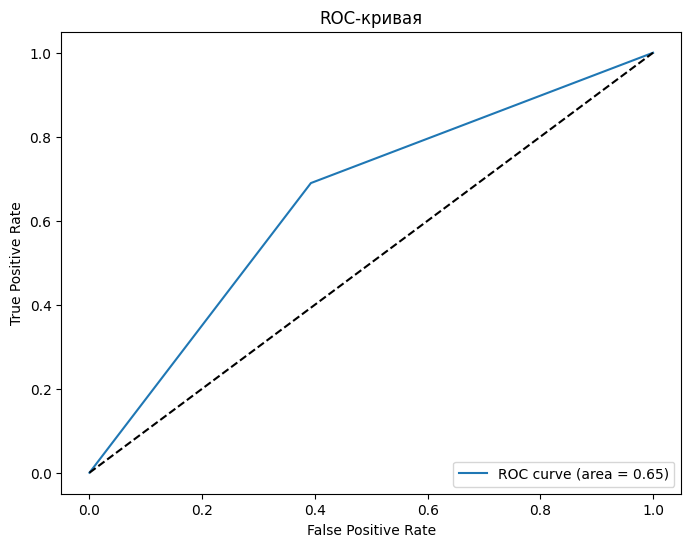

In [101]:
from sklearn.metrics import roc_curve, auc

Y_test_prob = model.predict_proba(X_test)[:, 1]

# Расчет ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test_bal, y_pred_bal)
roc_auc = auc(fpr, tpr)

# Построение графика
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

⏰ Общая точность модели составила 0.65, значит, модель 65% наблюдений классифицировала верно. Результат неплохой. 20 раз модель правильно предположила, что холестерин завышен и 17 раз определила верно, что холестерин точно норм. Ошибочно отнесла  11 с норм хол к повышенным хол и пропустила 9 человек. Tочность классификации составкила 0.65, значит, модель 65% людей, которые были с завышенным хол, классифицировала как больных. Полнота классификации равна 0.69, то есть модель нашла и отнесла к классу 69% от всех завыш. Гармоническое среднее между полнотой и точностью классификации - 0.67, это говорит о том, что метрики, в целом, сбалансированы. ROC-AUC равно 0.65, модель классифицирует лучше случайного угадывания, но имеет возможности для улучшения.

In [102]:
y = df['CHOL_50']

X = df.drop(['CHOL_50', 'CHOLNORM'], axis=1)

In [109]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True)



In [110]:
X

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH
0,42,1,110,65,64,147,2,8,4,120,78,271,146,2,1
1,53,1,130,72,69,167,1,6,2,122,68,250,165,9,1
2,53,2,120,90,70,222,4,8,1,132,90,304,223,2,1
3,48,4,120,80,72,229,4,8,2,118,68,209,227,3,1
4,53,3,118,74,66,134,3,8,5,118,56,261,138,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,2,8,1,115,65,273,152,0,0
196,23,1,110,70,69,137,3,8,2,112,76,198,153,0,0
197,20,3,130,80,66,150,5,0,1,130,85,274,158,0,0
198,46,3,140,84,66,138,4,6,2,148,88,160,157,0,0
